## Test the use of a pre-trained transformer model for text classification

### Load libraries

In [1]:
# Data wrangling
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from pyprojroot.here import here

# Model training
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.auto import tqdm
from datasets import load_metric

# Model evaluation
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocess data

In [2]:
# Load the training data and combine
data_path = here("data/training_data")
all_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".csv")]
df_list = [pd.read_csv(file) for file in all_files]
combined_df = pd.concat(df_list, ignore_index=True)

# Load the excel file containing category information
category_info = pd.read_excel(here("data/All_Updated_Categories_2019_edited_by_mikkel.xlsx"))

# Merge the dataframes
merged_df = pd.merge(
  combined_df, 
  category_info, 
  left_on = "SubType", 
  right_on = "subcategory",
  how = "left"
)

### Quality control

In [3]:
# Check the number of documents for each class, category, and subcategory
class_counts = merged_df['class'].value_counts()
subcategory_counts = merged_df['subcategory'].value_counts()

print("Class Counts:\n", class_counts)
print("\nSubcategory Counts:\n", subcategory_counts)

Class Counts:
 class
Infectious_Disease    27508
Other                 11514
Autoimm               11167
Cancer                10957
Allergen               4019
Transplant             1805
Name: count, dtype: int64

Subcategory Counts:
 subcategory
OTC       2885
OTFLU     2534
OTGA      2479
PLASMO    2183
SARS      2175
          ... 
FIB         23
METAL       23
BIME        20
INTG        17
PROST       16
Name: count, Length: 176, dtype: int64


In [4]:
missing_values = merged_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               8
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [5]:
# Look at the papers with missing titles
merged_df[merged_df.Title.isnull()]

,PubMed_ID,Title,Abstract,SubType,Class,Category,Subcategory,Abbreviation,OK,class,category,subcategory
5459,11006009,NaN,[Data extracted from this article was imported...,HCV,Infectious Disease,ssRNA (+) Strand Virus,Hepatitis C Virus,HCV,x,Infectious_Disease,ssRNA_positive,HCV
10499,8567982,NaN,[Data extracted from this article was imported...,HBV,Infectious Disease,Retro-Transcribing Virus,Hepatitis B Virus,HBV,x,Infectious_Disease,Retro-Transcribing_Virus,HBV
13215,11012976,NaN,[Data extracted from this article was imported...,OTFLU,Infectious Disease,ssRNA (-) Strand Virus,Other Influenza A Subtypes,OTFLU,x,Infectious_Disease,ssRNA_negative,OTFLU
16750,11426965,NaN,[Data extracted from this article was imported...,HPV,Infectious Disease,dsDNA Virus,Human papillomavirus,HPV,x,Infectious_Disease,dsDNA_Virus,HPV
24876,15585860,NaN,Structural and physiological facets of carbohy...,MOAB,Other,Peptidic Antigen,General Monoclonal Antibodies,MOAB,x,Other,Peptidic_Antigen,MOAB
44549,15001714,NaN,CD8 T lymphocytes recognize peptides of 8 to 1...,MAA,Cancer,NaN,"Tyrosinase, TRP2, GP100, TRP1, MART1, SOX10 (M...",MAA,x,Cancer,NaN,MAA
54471,29572442,NaN,The B cell survival factor (TNFSF13B/BAFF) is ...,OTLUP,Autoimmune,Lupus,Other,OTLUP,x,Autoimm,Lupus,OTLUP
63300,14724640,NaN,Cytotoxic T lymphocytes (CTLs) detect and dest...,RENAL,Cancer,NaN,Renal (RCC),RENAL,x,Cancer,NaN,RENAL


It seems like there are some of the abstract there are not extracted correctly.
They all starts with "[Data extracted from this article was imported...".

In [6]:
# Create a boolean mask for rows where the abstract starts with the specified string
mask = merged_df['Abstract'].str.startswith("[Data extracted from this article was imported")

# Filter out these rows
filtered_df = merged_df[~mask]

# Check the number of rows before and after filtering
print(f"Number of rows before filtering: {len(merged_df)}")
print(f"Number of rows after filtering: {len(filtered_df)}")
print(f"Difference: {len(merged_df) - len(filtered_df)}")


Number of rows before filtering: 67457
Number of rows after filtering: 67403
Difference: 54


In [7]:
missing_values = filtered_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 PubMed_ID           0
Title               4
Abstract            0
SubType             0
Class             487
Category        16265
Subcategory       487
Abbreviation      487
OK                487
class             487
category        16265
subcategory       487
dtype: int64


In [8]:
### Split the Data for the class variable
target = "class"

# Drop rows where 'class' is NA
filtered_df = filtered_df.dropna(subset=[target])

# Check the number of rows after dropping
print(f"Number of rows after dropping NAs in target: {len(filtered_df)}")

# Split the data into train and a temporary dataset (70% train, 30% temp)
train_df, temp_df = train_test_split(filtered_df, test_size=0.3, random_state=42, stratify=filtered_df[target])

# Split the temporary dataset into validation and test datasets (50% validation, 50% test from the temp dataset)
eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[target])

# Initialize the label encoder
label_encoder = LabelEncoder()

# Transform class label from string to integers
# Fit the encoder on the 'class' column and transform it
train_df['target_int'] = label_encoder.fit_transform(train_df[target])
eval_df['target_int'] = label_encoder.transform(eval_df[target])
test_df['target_int'] = label_encoder.transform(test_df[target])


# Check the number of rows in each dataset
print(f"Number of rows in train dataset: {len(train_df)}")
print(f"Number of rows in validation dataset: {len(eval_df)}")
print(f"Number of rows in test dataset: {len(test_df)}")

Number of rows after dropping NAs in target: 66916
Number of rows in train dataset: 46841
Number of rows in validation dataset: 10037
Number of rows in test dataset: 10038


In [9]:
# Check the number of documents from each class in the train dataset
train_class_counts = train_df[target].value_counts()

# Check the number of documents from each class in the validation dataset
valid_class_counts = eval_df[target].value_counts()

# Check the number of documents from each class in the test dataset
test_class_counts = test_df[target].value_counts()

print("Number of documents from each class in train dataset:\n", train_class_counts)
print("\nNumber of documents from each class in validation dataset:\n", valid_class_counts)
print("\nNumber of documents from each class in test dataset:\n", test_class_counts)

Number of documents from each class in train dataset:
 class
Infectious_Disease    19219
Other                  8058
Autoimm                7817
Cancer                 7670
Allergen               2813
Transplant             1264
Name: count, dtype: int64

Number of documents from each class in validation dataset:
 class
Infectious_Disease    4118
Other                 1727
Autoimm               1675
Cancer                1643
Allergen               603
Transplant             271
Name: count, dtype: int64

Number of documents from each class in test dataset:
 class
Infectious_Disease    4119
Other                 1727
Autoimm               1675
Cancer                1644
Allergen               603
Transplant             270
Name: count, dtype: int64


### Fine-tune the BioBert transformer model

In [10]:
# Load BioBERT and tokenizer
model_name = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = BertTokenizer.from_pretrained(model_name)
num_labels = len(train_df['target_int'].unique())
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 1. Tokenization
data_size = 1000
train_abstract = train_df['Abstract'].tolist()[1:data_size]
eval_abstract = eval_df['Abstract'].tolist()[1:data_size]
tokenized_train = tokenizer(train_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)
tokenized_eval = tokenizer(eval_abstract, padding=True, truncation=True, return_tensors="pt", max_length=512)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# Convert tokenized data to PyTorch dataset
train_labels = train_df['target_int'].tolist()[1:data_size]
eval_labels = eval_df["target_int"].tolist()[1:data_size]
train_dataset = CustomDataset(encodings = tokenized_train, labels = train_labels)
eval_dataset = CustomDataset(encodings = tokenized_eval, labels = eval_labels)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(eval_dataset, batch_size=8)


In [12]:
# 2. Training Loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear", 
    optimizer=optimizer, 
    num_warmup_steps=0, 
    num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()

# For accumulating loss over the epoch
total_loss = 0.0

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        
        # Add the batch loss to the total loss
        total_loss += loss.item()

        progress_bar.update(1)
        
        # Print loss for the current batch
        print(f"Batch Loss: {loss.item():.4f}")
    
    # Print average loss for the epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    
    # Reset total_loss for the next epoch
    total_loss = 0.0


  1%|          | 1/125 [00:09<19:00,  9.20s/it]

Batch Loss: 2.0424


  2%|▏         | 2/125 [00:18<18:41,  9.12s/it]

Batch Loss: 1.8039


  2%|▏         | 3/125 [00:26<17:46,  8.74s/it]

Batch Loss: 1.9148


  3%|▎         | 4/125 [00:35<17:24,  8.64s/it]

Batch Loss: 1.8323


  4%|▍         | 5/125 [00:43<17:05,  8.55s/it]

Batch Loss: 1.8816


  5%|▍         | 6/125 [00:51<16:54,  8.52s/it]

Batch Loss: 1.6238


  6%|▌         | 7/125 [01:00<16:36,  8.45s/it]

Batch Loss: 1.5637


  6%|▋         | 8/125 [01:08<16:28,  8.45s/it]

Batch Loss: 1.6143


  7%|▋         | 9/125 [01:17<16:24,  8.48s/it]

Batch Loss: 1.7581


  8%|▊         | 10/125 [01:25<15:57,  8.32s/it]

Batch Loss: 1.4491


  9%|▉         | 11/125 [01:33<15:42,  8.27s/it]

Batch Loss: 1.5529


 10%|▉         | 12/125 [01:41<15:41,  8.33s/it]

Batch Loss: 1.8366


 10%|█         | 13/125 [01:49<15:29,  8.30s/it]

Batch Loss: 1.6233


 11%|█         | 14/125 [01:58<15:36,  8.43s/it]

Batch Loss: 1.6266


 12%|█▏        | 15/125 [02:07<15:40,  8.55s/it]

Batch Loss: 1.4607


 13%|█▎        | 16/125 [02:16<15:33,  8.56s/it]

Batch Loss: 1.7762


 14%|█▎        | 17/125 [02:24<15:14,  8.46s/it]

Batch Loss: 1.2854


 14%|█▍        | 18/125 [02:33<15:10,  8.51s/it]

Batch Loss: 1.4173


 15%|█▌        | 19/125 [02:41<14:47,  8.38s/it]

Batch Loss: 1.1678


 16%|█▌        | 20/125 [02:49<14:41,  8.39s/it]

Batch Loss: 1.3034


 17%|█▋        | 21/125 [02:57<14:31,  8.38s/it]

Batch Loss: 1.1117


 18%|█▊        | 22/125 [03:06<14:18,  8.34s/it]

Batch Loss: 2.7434


 18%|█▊        | 23/125 [03:14<13:59,  8.23s/it]

Batch Loss: 1.5694


 19%|█▉        | 24/125 [03:22<13:52,  8.24s/it]

Batch Loss: 1.3265


 20%|██        | 25/125 [03:30<13:50,  8.31s/it]

Batch Loss: 1.7486


 21%|██        | 26/125 [03:38<13:39,  8.27s/it]

Batch Loss: 1.7363


 22%|██▏       | 27/125 [03:47<13:41,  8.38s/it]

Batch Loss: 1.2916


 22%|██▏       | 28/125 [03:55<13:28,  8.33s/it]

Batch Loss: 1.0593


 23%|██▎       | 29/125 [04:04<13:20,  8.34s/it]

Batch Loss: 1.8269


 24%|██▍       | 30/125 [04:12<13:02,  8.24s/it]

Batch Loss: 1.3618


 25%|██▍       | 31/125 [04:20<12:50,  8.20s/it]

Batch Loss: 2.1450


 26%|██▌       | 32/125 [04:28<12:47,  8.25s/it]

Batch Loss: 1.4635


 26%|██▋       | 33/125 [04:36<12:35,  8.22s/it]

Batch Loss: 1.4501


 27%|██▋       | 34/125 [04:44<12:21,  8.14s/it]

Batch Loss: 1.6320


 28%|██▊       | 35/125 [04:52<12:03,  8.04s/it]

Batch Loss: 1.8728


 29%|██▉       | 36/125 [05:00<11:52,  8.00s/it]

Batch Loss: 1.4057


 30%|██▉       | 37/125 [05:08<11:43,  7.99s/it]

Batch Loss: 1.3812


 30%|███       | 38/125 [05:16<11:42,  8.08s/it]

Batch Loss: 2.0046


 31%|███       | 39/125 [05:24<11:30,  8.03s/it]

Batch Loss: 1.3562


 32%|███▏      | 40/125 [05:32<11:14,  7.93s/it]

Batch Loss: 1.7000


 33%|███▎      | 41/125 [05:40<11:01,  7.88s/it]

Batch Loss: 1.5811


 34%|███▎      | 42/125 [05:48<10:59,  7.95s/it]

Batch Loss: 1.4164


 34%|███▍      | 43/125 [05:56<10:54,  7.99s/it]

Batch Loss: 1.6210


 35%|███▌      | 44/125 [06:04<10:46,  7.98s/it]

Batch Loss: 2.0627


 36%|███▌      | 45/125 [06:12<10:42,  8.03s/it]

Batch Loss: 1.7496


 37%|███▋      | 46/125 [06:20<10:36,  8.06s/it]

Batch Loss: 1.4549


 38%|███▊      | 47/125 [06:28<10:26,  8.03s/it]

Batch Loss: 1.5633


 38%|███▊      | 48/125 [06:36<10:13,  7.97s/it]

Batch Loss: 1.4559


 39%|███▉      | 49/125 [06:44<10:00,  7.90s/it]

Batch Loss: 1.6856


 40%|████      | 50/125 [06:51<09:48,  7.85s/it]

Batch Loss: 1.3961


 41%|████      | 51/125 [06:59<09:35,  7.78s/it]

Batch Loss: 1.6483


 42%|████▏     | 52/125 [07:07<09:30,  7.81s/it]

Batch Loss: 1.2325


 42%|████▏     | 53/125 [07:15<09:19,  7.78s/it]

Batch Loss: 1.6874


 43%|████▎     | 54/125 [07:22<09:13,  7.79s/it]

Batch Loss: 0.9441


 44%|████▍     | 55/125 [07:30<09:06,  7.81s/it]

Batch Loss: 0.9790


 45%|████▍     | 56/125 [07:38<08:59,  7.82s/it]

Batch Loss: 1.1909


 46%|████▌     | 57/125 [07:46<08:49,  7.79s/it]

Batch Loss: 1.4189


 46%|████▋     | 58/125 [07:54<08:42,  7.80s/it]

Batch Loss: 0.7816


 47%|████▋     | 59/125 [08:01<08:37,  7.83s/it]

Batch Loss: 1.0767


 48%|████▊     | 60/125 [08:10<08:35,  7.93s/it]

Batch Loss: 1.1077


 49%|████▉     | 61/125 [08:17<08:24,  7.88s/it]

Batch Loss: 1.0033


 50%|████▉     | 62/125 [08:26<08:30,  8.10s/it]

Batch Loss: 1.0886


 50%|█████     | 63/125 [08:34<08:20,  8.07s/it]

Batch Loss: 0.9750


 51%|█████     | 64/125 [08:42<08:13,  8.08s/it]

Batch Loss: 1.2042


 52%|█████▏    | 65/125 [08:50<08:08,  8.14s/it]

Batch Loss: 0.7238


 53%|█████▎    | 66/125 [08:59<08:01,  8.16s/it]

Batch Loss: 0.6524


 54%|█████▎    | 67/125 [09:07<07:52,  8.15s/it]

Batch Loss: 1.0844


 54%|█████▍    | 68/125 [09:15<07:38,  8.05s/it]

Batch Loss: 1.7141


 55%|█████▌    | 69/125 [09:23<07:32,  8.08s/it]

Batch Loss: 0.9861


 56%|█████▌    | 70/125 [09:31<07:22,  8.04s/it]

Batch Loss: 1.4713


 57%|█████▋    | 71/125 [09:39<07:14,  8.04s/it]

Batch Loss: 0.6846


 58%|█████▊    | 72/125 [09:47<07:08,  8.09s/it]

Batch Loss: 1.1904


 58%|█████▊    | 73/125 [09:55<06:59,  8.08s/it]

Batch Loss: 0.8418


 59%|█████▉    | 74/125 [10:03<06:54,  8.12s/it]

Batch Loss: 1.8546


 60%|██████    | 75/125 [10:11<06:43,  8.06s/it]

Batch Loss: 0.4671


 61%|██████    | 76/125 [10:19<06:31,  7.99s/it]

Batch Loss: 0.8564


 62%|██████▏   | 77/125 [10:27<06:24,  8.02s/it]

Batch Loss: 0.9505


 62%|██████▏   | 78/125 [10:35<06:20,  8.09s/it]

Batch Loss: 0.9791


 63%|██████▎   | 79/125 [10:43<06:08,  8.00s/it]

Batch Loss: 0.4748


 64%|██████▍   | 80/125 [10:51<06:05,  8.12s/it]

Batch Loss: 0.4736


 65%|██████▍   | 81/125 [11:00<06:01,  8.21s/it]

Batch Loss: 0.9200


 66%|██████▌   | 82/125 [11:08<05:52,  8.19s/it]

Batch Loss: 0.6412


 66%|██████▋   | 83/125 [11:16<05:42,  8.16s/it]

Batch Loss: 0.9271


 67%|██████▋   | 84/125 [11:24<05:36,  8.22s/it]

Batch Loss: 0.8709


 68%|██████▊   | 85/125 [11:33<05:32,  8.32s/it]

Batch Loss: 0.5771


 69%|██████▉   | 86/125 [11:41<05:21,  8.25s/it]

Batch Loss: 0.6518


 70%|██████▉   | 87/125 [11:49<05:11,  8.20s/it]

Batch Loss: 0.7660


 70%|███████   | 88/125 [11:57<05:01,  8.16s/it]

Batch Loss: 0.6133


 71%|███████   | 89/125 [12:06<04:56,  8.22s/it]

Batch Loss: 1.1072


 72%|███████▏  | 90/125 [12:14<04:46,  8.19s/it]

Batch Loss: 0.8627


 73%|███████▎  | 91/125 [12:22<04:38,  8.20s/it]

Batch Loss: 0.5940


 74%|███████▎  | 92/125 [12:30<04:26,  8.09s/it]

Batch Loss: 0.7092


 74%|███████▍  | 93/125 [12:37<04:09,  7.80s/it]

Batch Loss: 0.9613


 75%|███████▌  | 94/125 [12:44<03:57,  7.67s/it]

Batch Loss: 0.8263


 76%|███████▌  | 95/125 [12:51<03:45,  7.51s/it]

Batch Loss: 0.3745


 77%|███████▋  | 96/125 [12:58<03:31,  7.30s/it]

Batch Loss: 0.9070


 78%|███████▊  | 97/125 [13:05<03:18,  7.10s/it]

Batch Loss: 0.9641


 78%|███████▊  | 98/125 [13:12<03:09,  7.02s/it]

Batch Loss: 0.7027


 79%|███████▉  | 99/125 [13:18<03:00,  6.95s/it]

Batch Loss: 0.5828


 80%|████████  | 100/125 [13:25<02:54,  6.96s/it]

Batch Loss: 0.7088


 81%|████████  | 101/125 [13:32<02:45,  6.91s/it]

Batch Loss: 0.4490


 82%|████████▏ | 102/125 [13:39<02:38,  6.90s/it]

Batch Loss: 0.7104


 82%|████████▏ | 103/125 [13:46<02:31,  6.86s/it]

Batch Loss: 0.2025


 83%|████████▎ | 104/125 [13:53<02:23,  6.81s/it]

Batch Loss: 0.8733


 84%|████████▍ | 105/125 [13:59<02:16,  6.81s/it]

Batch Loss: 0.8126


 85%|████████▍ | 106/125 [14:07<02:11,  6.92s/it]

Batch Loss: 0.5823


 86%|████████▌ | 107/125 [14:14<02:05,  7.00s/it]

Batch Loss: 1.4355


 86%|████████▋ | 108/125 [14:21<01:59,  7.03s/it]

Batch Loss: 0.3036


 87%|████████▋ | 109/125 [14:28<01:52,  7.01s/it]

Batch Loss: 0.8987


 88%|████████▊ | 110/125 [14:35<01:46,  7.07s/it]

Batch Loss: 0.6405


 89%|████████▉ | 111/125 [14:42<01:39,  7.14s/it]

Batch Loss: 0.6312


 90%|████████▉ | 112/125 [14:50<01:33,  7.19s/it]

Batch Loss: 1.0738


 90%|█████████ | 113/125 [14:57<01:25,  7.15s/it]

Batch Loss: 1.0045


 91%|█████████ | 114/125 [15:04<01:18,  7.15s/it]

Batch Loss: 0.4663


 92%|█████████▏| 115/125 [15:11<01:11,  7.14s/it]

Batch Loss: 0.5904


 93%|█████████▎| 116/125 [15:18<01:04,  7.12s/it]

Batch Loss: 0.4788


 94%|█████████▎| 117/125 [15:25<00:56,  7.10s/it]

Batch Loss: 0.1452


 94%|█████████▍| 118/125 [15:32<00:49,  7.09s/it]

Batch Loss: 1.0128


 95%|█████████▌| 119/125 [15:39<00:42,  7.03s/it]

Batch Loss: 0.7677


 96%|█████████▌| 120/125 [15:46<00:34,  6.98s/it]

Batch Loss: 0.5337


 97%|█████████▋| 121/125 [15:53<00:28,  7.04s/it]

Batch Loss: 0.3453


 98%|█████████▊| 122/125 [16:00<00:21,  7.13s/it]

Batch Loss: 1.1090


 98%|█████████▊| 123/125 [16:07<00:14,  7.06s/it]

Batch Loss: 0.4145


 99%|█████████▉| 124/125 [16:14<00:07,  7.04s/it]

Batch Loss: 2.0147


100%|██████████| 125/125 [16:20<00:00,  6.64s/it]

Batch Loss: 0.7412
Epoch 1 Average Loss: 1.1676


In [13]:
# 3. Evaluation
metric = load_metric("accuracy")

# Store probabilities, predictions and true labels
all_scores = []
all_predictions = []
all_true_labels = []

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits

    # Get probabilities and predictions
    scores = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # For computing the metric
    metric.add_batch(predictions=predictions, references=batch["labels"])

    # Save probabilites, predictions and labels
    all_scores.extend(scores)
    all_predictions.extend(predictions)
    all_true_labels.extend(batch["labels"].cpu().numpy())

print(metric.compute())

/var/folders/3y/5f9vshgx76d1z8vmnfwj_xqc0000gn/T/ipykernel_18379/227657001.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


{'accuracy': 0.7907907907907908}


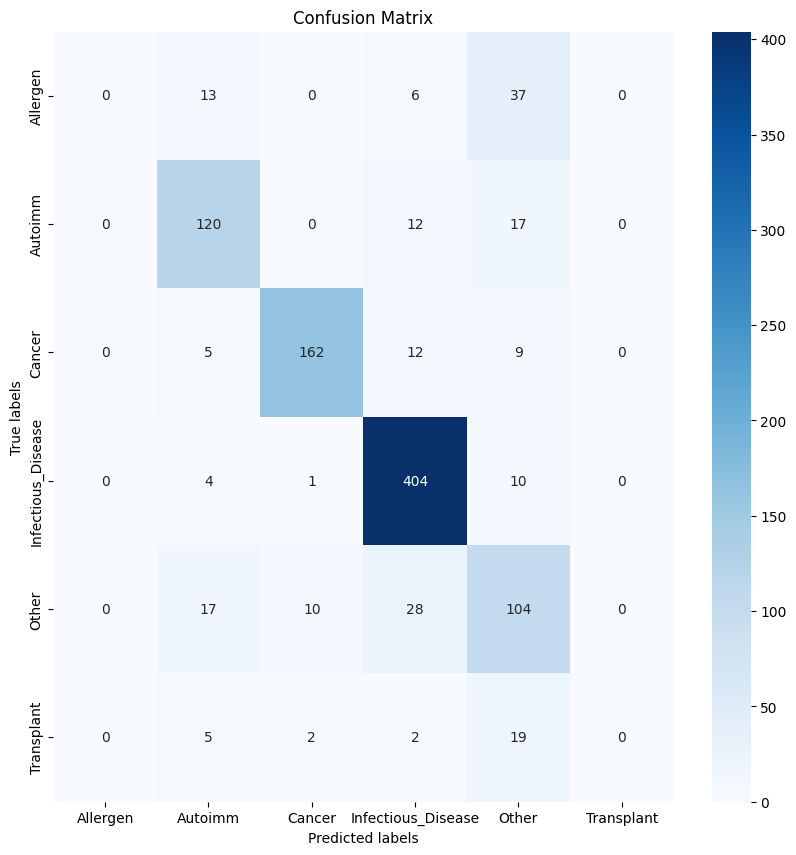

In [14]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(here("results/biobert_fine_tune_1000_class_confusion_matrix.png"))
plt.show()


In [24]:
metrics = classification_report(all_true_labels, all_predictions, target_names=label_encoder.classes_)
with open(here("results/biobert_classification_report_1000.csv"), "w") as text_file:
    text_file.write(metrics)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

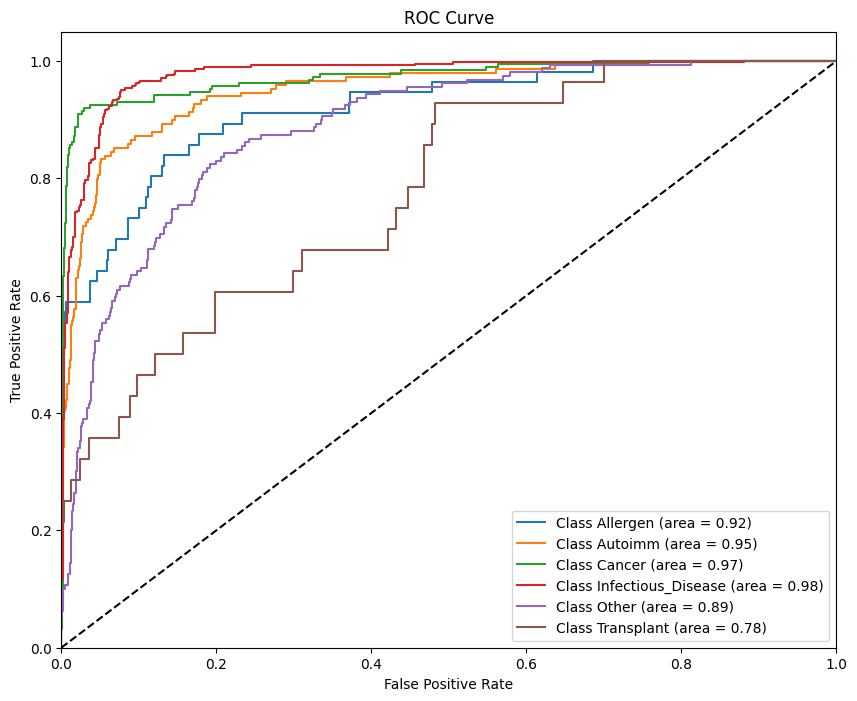

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels for multi-class ROC
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

plt.figure(figsize=(10, 8))

# Compute ROC curve and ROC area for each class
for i in range(len(label_encoder.classes_)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()



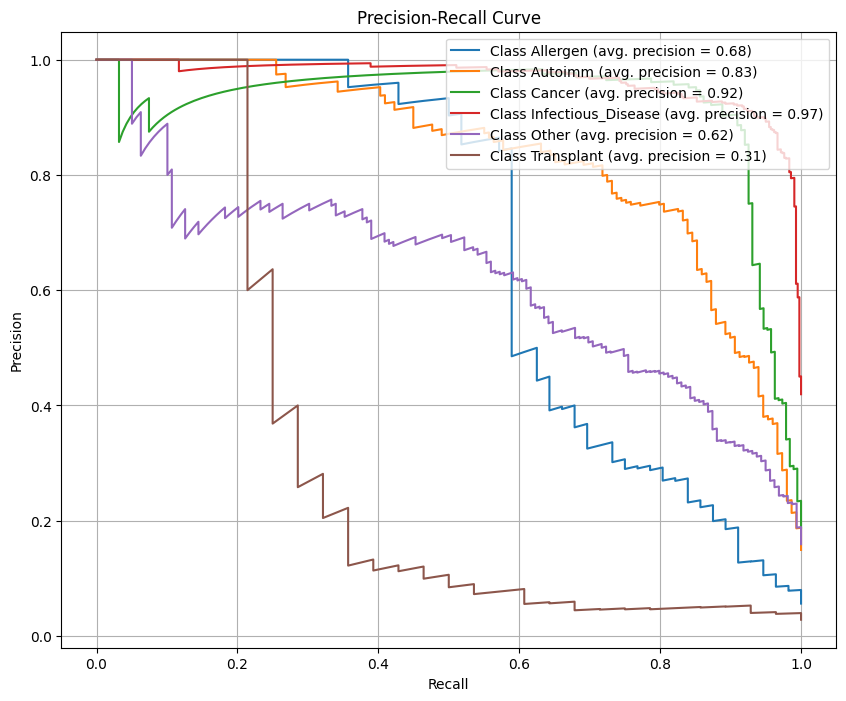

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))

# Compute Precision-Recall and plot curve for each class
for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(true_labels_bin[:, i], np.array(all_scores)[:, i])
    avg_precision = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    plt.plot(recall, precision, label=f'Class {label_encoder.classes_[i]} (avg. precision = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()


In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score

roc_aucs = []
pr_aucs = []

# Binarize the labels for multi-class AUC calculation
true_labels_bin = label_binarize(all_true_labels, classes=np.arange(len(label_encoder.classes_)))

# Calculate AUC for each class
for i in range(len(label_encoder.classes_)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    pr_auc = average_precision_score(true_labels_bin[:, i], np.array(all_scores)[:, i])
    
    roc_aucs.append(roc_auc)
    pr_aucs.append(pr_auc)


# Create a DataFrame
df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs
})

# Display the table
print(df)


                Class   ROC AUC    PR AUC
0            Allergen  0.919160  0.683594
1             Autoimm  0.950312  0.834779
2              Cancer  0.972427  0.921429
3  Infectious_Disease  0.977298  0.967060
4               Other  0.887728  0.621802
5          Transplant  0.779866  0.314728


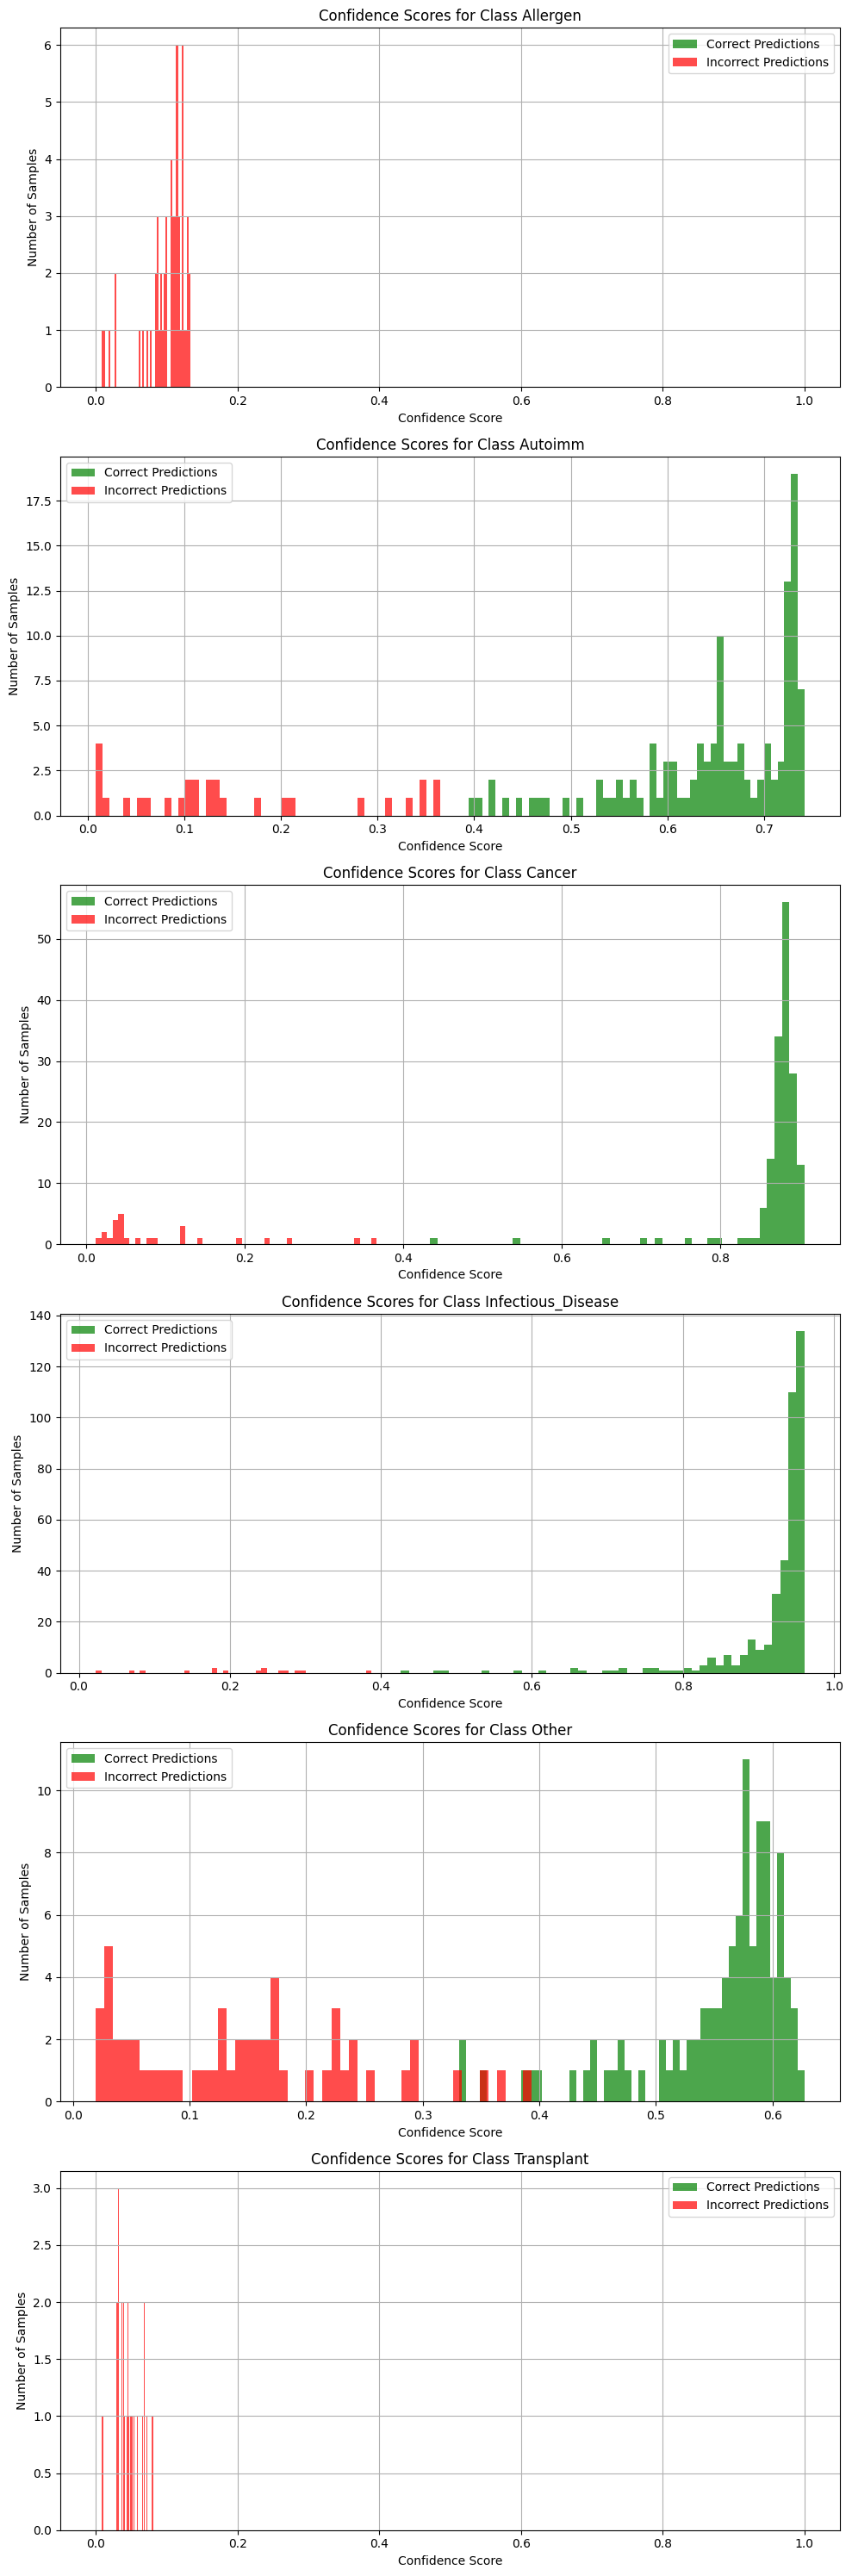

In [20]:
# Convert predictions and true labels to a numpy array for easier indexing
predicted_classes = np.array(all_predictions)
true_classes = np.array(all_true_labels)

# Number of classes
num_classes = len(label_encoder.classes_)

all_scores_np = np.array(all_scores)

# Plot histograms for confidence scores of each class separately
fig, axes = plt.subplots(num_classes, 1, figsize=(10, 5 * num_classes))

for i in range(num_classes):
    # Correct predictions for this class
    correct_mask = (predicted_classes == i) & (true_classes == i)
    incorrect_mask = (predicted_classes != i) & (true_classes == i)
    
    axes[i].hist(all_scores_np[correct_mask, i], bins=50, color='green', alpha=0.7, label='Correct Predictions')
    axes[i].hist(all_scores_np[incorrect_mask, i], bins=50, color='red', alpha=0.7, label='Incorrect Predictions')
    
    axes[i].set_title(f'Confidence Scores for Class {label_encoder.classes_[i]}')
    axes[i].set_xlabel('Confidence Score')
    axes[i].set_ylabel('Number of Samples')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()
